In [3]:
from google.colab import files
uploaded = files.upload()

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


In [0]:
#Importing the dependencies

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scipy.stats as stats

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [5]:
##Load the dataset

file=open("WISDM_ar_v1.1_raw.txt")
lines=file.readlines()
processedList=[]
for i,line in enumerate(lines):
  try:
    line=line.split(',')
    last=line[5].split(';')[0]
    last=last.strip()
    if last == '':
      break;
    temp=[line[0],line[1],line[2],line[3],line[4],last]
    processedList.append(temp)
  except:
      print('Error at line number: ',i)


Error at line number:  281873
Error at line number:  281874
Error at line number:  281875
Error at line number:  537501
Error at line number:  832901
Error at line number:  1098209


In [12]:
processedList

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [13]:
columns=['User','Activity','Time','x','y','z']
data=pd.DataFrame(data=processedList,columns=columns)
data.head()

,User,Activity,Time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [14]:
#Get insights for the data 
print("Data shape: ",(data.shape))
data.info()
print("The null values in th data are: ",data.isnull().sum().sum())

Data shape:  (1098204, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
User        1098204 non-null object
Activity    1098204 non-null object
Time        1098204 non-null object
x           1098204 non-null object
y           1098204 non-null object
z           1098204 non-null object
dtypes: object(6)
memory usage: 50.3+ MB
The null values in th data are:  0


In [0]:

data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [15]:
data.describe()

,User,Activity,Time,x,y,z
count,1098204,1098204,1098204,1098204,1098204,1098204
unique,36,6,1006170,1856,1812,2112
top,20,Walking,0,0,19.57,0.0
freq,56632,424398,12843,16444,16345,12823


In [22]:
Hz=20 #sample rate which is given in the readme file of the dataset 

activities = data['Activity'].value_counts().index
activities


Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

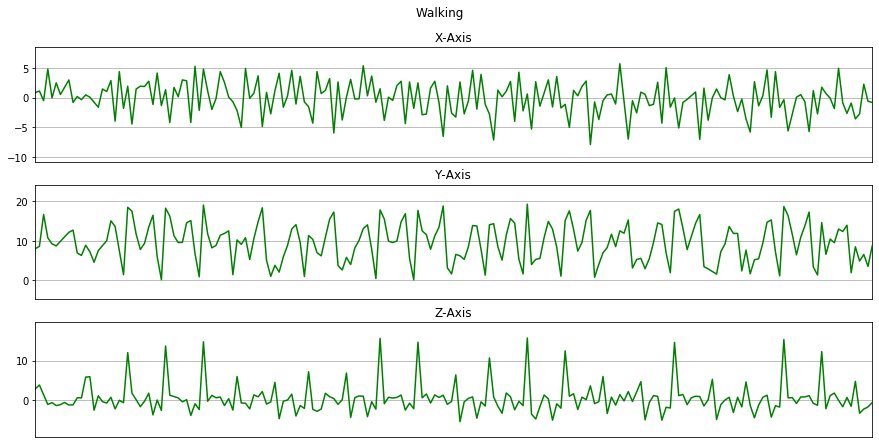

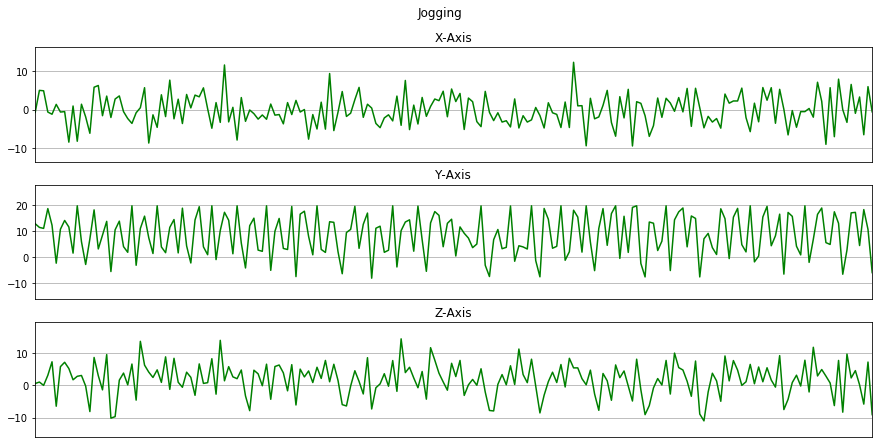

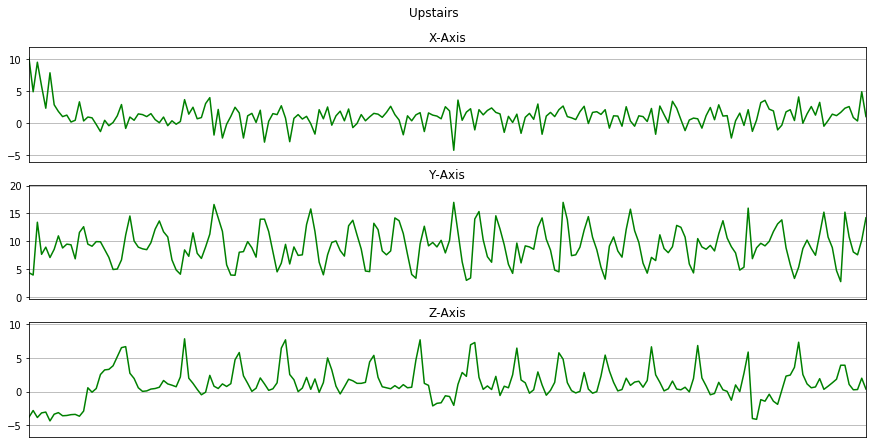

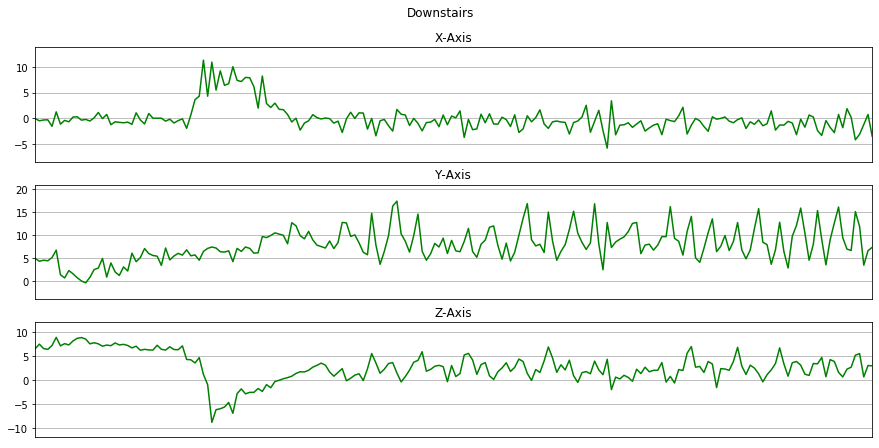

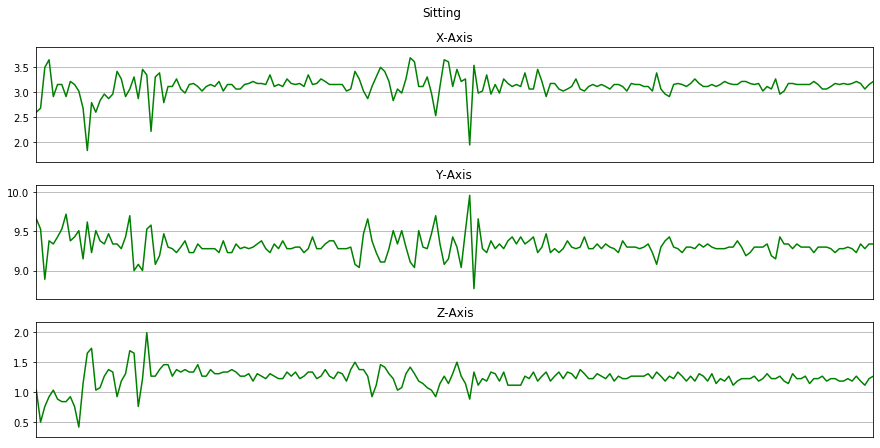

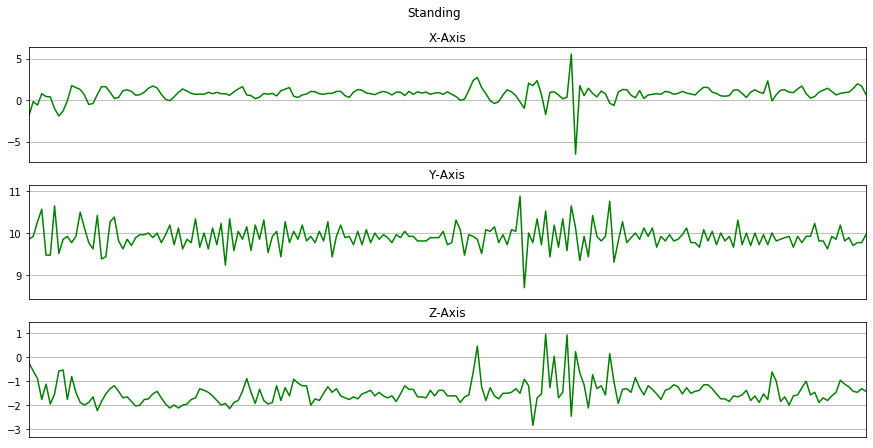

In [28]:
#ploting the data :
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['Time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['Time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['Time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['Activity'] == activity)][:Hz*10]
    plot_activity(activity, data_for_plot)

In [0]:
data['Activity'].value_counts()

Walking       424398
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: Activity, dtype: int64

In [0]:
##There's a high diffrence between the acitivties,
##so if we take in the data as it is, there's a high chance of overfitting and skewness occur to the high activitys values(walking,jogging),
##so we need to balance the data 

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
User        1098204 non-null object
Activity    1098204 non-null object
Time        1098204 non-null object
x           1098204 non-null float64
y           1098204 non-null float64
z           1098204 non-null float64
dtypes: float64(3), object(3)
memory usage: 50.3+ MB


In [30]:
#Drop the user and time columns :
data=data.drop(['User','Time'],axis=1).copy()
data.head()


,Activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [0]:
#for balancing the data lets take the min. value count for all the activity( which is in our case, 'standing' with 48395 input)
Walking = data[data['Activity']=='Walking'].head(48395).copy()
Jogging = data[data['Activity']=='Jogging'].head(48395).copy()
Upstairs = data[data['Activity']=='Upstairs'].head(48395).copy()
Downstairs = data[data['Activity']=='Downstairs'].head(48395).copy()
Sitting = data[data['Activity']=='Sitting'].head(48395).copy()
Standing = data[data['Activity']=='Standing'].copy()

In [32]:
New_df = pd.DataFrame()
New_df = New_df.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
New_df.shape

(290370, 4)

In [33]:
New_df.head()

,Activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [34]:
New_df['Activity'].value_counts()

Jogging       48395
Upstairs      48395
Downstairs    48395
Walking       48395
Sitting       48395
Standing      48395
Name: Activity, dtype: int64

In [35]:
#Encode the activity:
label = LabelEncoder()
New_df['label'] = label.fit_transform(New_df['Activity'])
New_df.head()


,Activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [36]:
##x,y,z dont have the same variance so we need to scale the data 
#Standardized data:
X = New_df[['x', 'y', 'z']]
y= New_df['label']
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head(10)

,x,y,z,label
0,-0.034489,0.076967,0.266487,5
1,0.017285,0.187547,0.495750,5
2,-0.290769,1.637371,-0.075839,5
3,0.716230,0.573348,-0.650569,5
4,-0.202754,0.298127,-0.537507,5
5,0.278742,0.207206,-0.713381,5
6,-0.094029,0.416079,-0.659991,5
7,0.138953,0.622494,-0.528086,5
8,0.371934,0.823995,-0.678834,5
9,-0.347720,0.927203,-0.669413,5


In [0]:
##For predicting the activity we need to take frame of time for each activity 

#Frame preparation for 5sec.

Hz=20
frame_size=Hz*5
hop_size= Hz*2

In [0]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [0]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [40]:
X.shape, y.shape

((7257, 100, 3), (7257,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


In [42]:
X_train.shape, X_test.shape

((5805, 100, 3), (1452, 100, 3))

In [43]:
X_train[0].shape, X_test[0].shape

((100, 3), (100, 3))

In [0]:
#Reshaping the data to 2D 
X_train = X_train.reshape(5805, 100, 3, 1)
X_test = X_test.reshape(1452, 100, 3, 1)

In [45]:
X_train[0].shape, X_test[0].shape

((100, 3, 1), (100, 3, 1))

In [48]:
#Building the model (2D CNN model):
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#Compiling the model:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [50]:
#Fit the model:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Train on 5805 samples, validate on 1452 samples
Epoch 1/10
5805/5805 [==============================] - 7s 1ms/sample - loss: 0.9114 - acc: 0.6288 - val_loss: 0.5313 - val_acc: 0.7982
Epoch 2/10
5805/5805 [==============================] - 1s 132us/sample - loss: 0.5733 - acc: 0.7643 - val_loss: 0.4166 - val_acc: 0.8519
Epoch 3/10
5805/5805 [==============================] - 1s 129us/sample - loss: 0.4520 - acc: 0.8117 - val_loss: 0.3338 - val_acc: 0.8795
Epoch 4/10
5805/5805 [==============================] - 1s 131us/sample - loss: 0.3615 - acc: 0.8562 - val_loss: 0.2694 - val_acc: 0.9112
Epoch 5/10
5805/5805 [==============================] - 1s 124us/sample - loss: 0.3193 - acc: 0.8760 - val_loss: 0.2419 - val_acc: 0.9215
Epoch 6/10
5805/5805 [==============================] - 1s 131us/sample - loss: 0.2744 - acc: 0.8932 - val_loss: 0.2130 - val_acc: 0.9284
Epoch 7/10
5805/5805 [==============================] - 1s 125us/sample - loss: 0.2444 - acc: 0.9025 - val_loss: 0.2006 - val_

In [53]:
#Evaluate the model on the Test data 
model.evaluate(X_test, y_test)

1452/1452 [==============================] - 0s 82us/sample - loss: 0.1577 - acc: 0.9483


[0.1576552308541684, 0.9483471]

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 99, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 1, 32)         2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                200768    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               